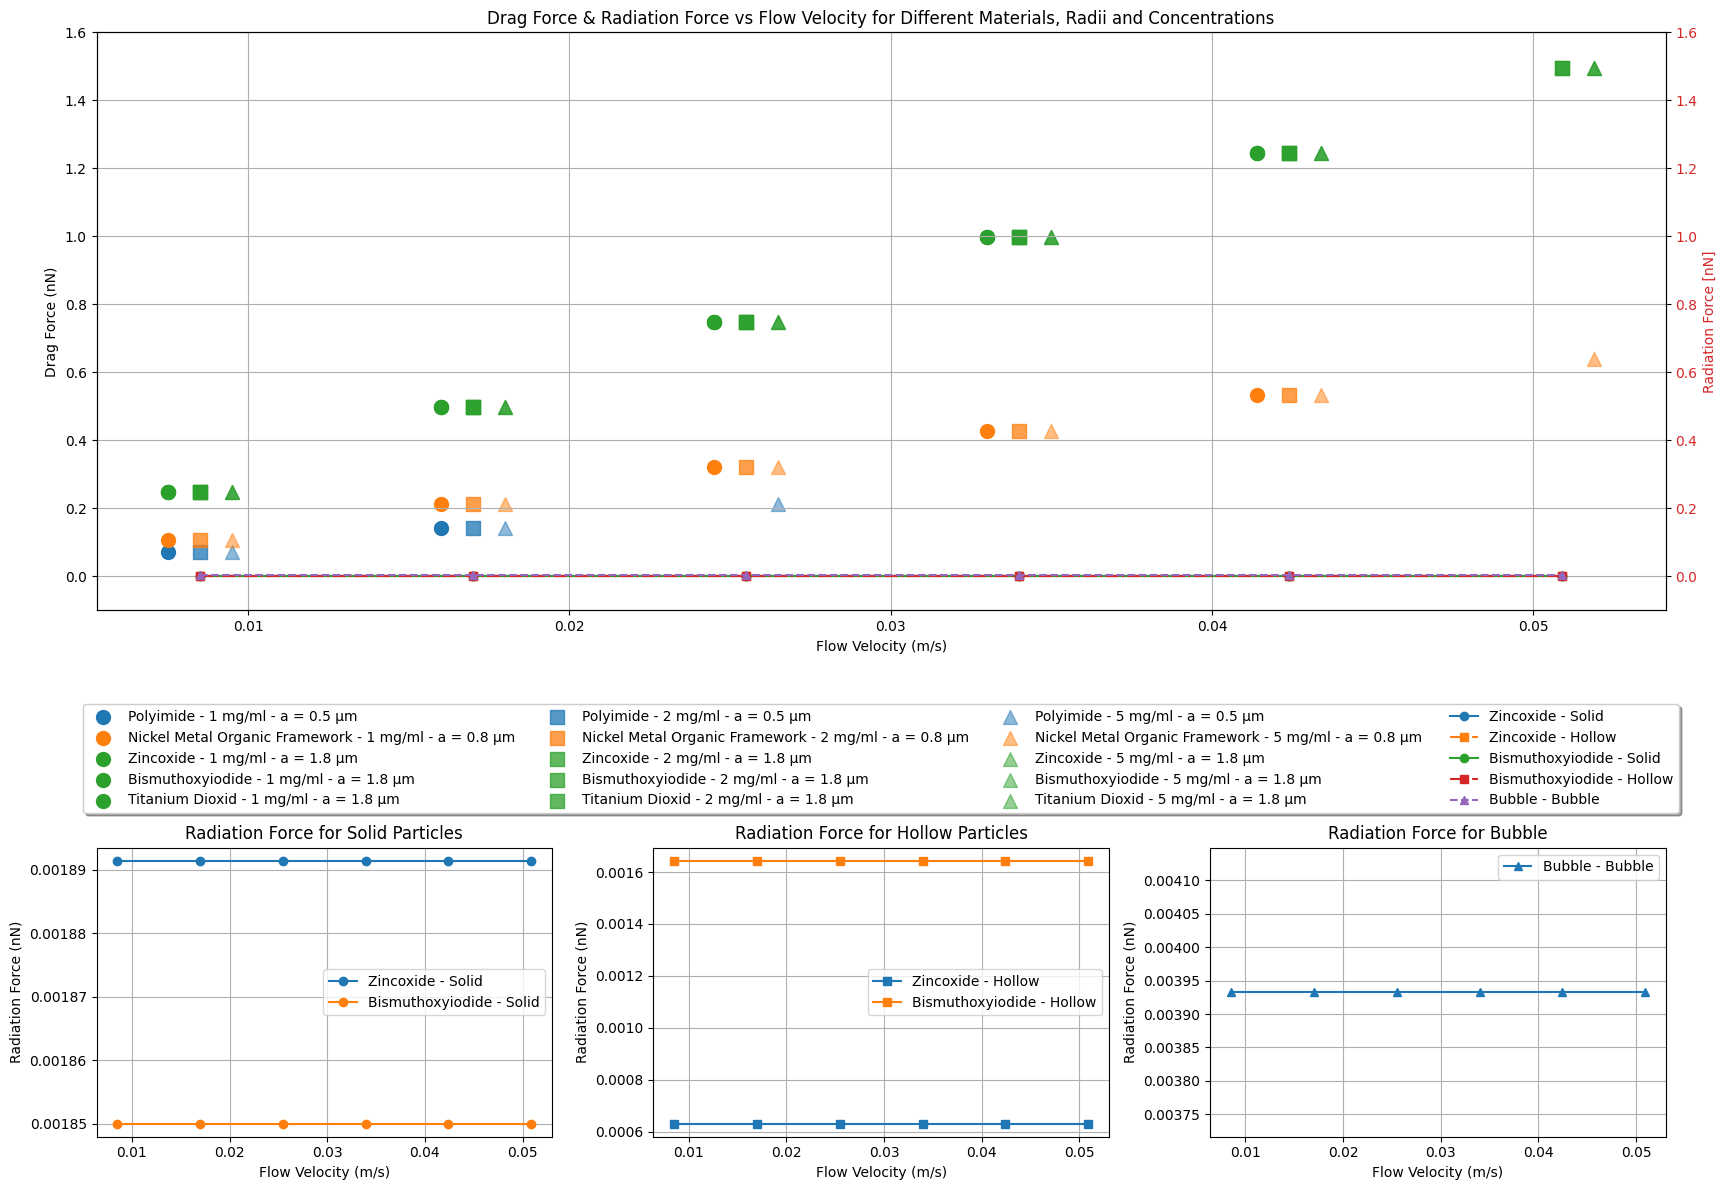

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Define Parameters
pi = math.pi 
p_a = 500000                      # acoustic pressure in Pa  
c_0 = 1497                        # speed of sound in fluid [m/s]
f = 2e6                           # frequency [Hz]
lam = c_0/f                       # wavelength [m]
k = (2*pi)/lam        
rho_0 = 998                       # density of fluid [kg/m^3]
mu = 0.00089                      # dynamic viscosity of fluid (here water) in [Pa s]
k_0 = 1/(rho_0*c_0**2)            # compressibility of fluid
z = 1

# Particle properties
particle_properties = {
    'Polyimide': {
        'a': 0.5e-6,              # radius [m]
        'v_1': 0.017,             # maximum trapping flow concentration 1mg/ml [m/s]
        'v_2': 0.017,             # maximum trapping flow concentration 2mg/ml [m/s]  
        'v_5': 0.0255             # maximum trapping flow concentration 5mg/ml [m/s]  
    },
    'Nickel Metal Organic Framework': {
        'a': 0.75e-6,
        'v_1': 0.0424,           
        'v_2': 0.0424,            
        'v_5': 0.0509             
    },
    'Zincoxide': {
        'rho': 5610,              # density [kg/m3]
        'k': 4.02e-12,            # compressibility [Pa^-1]
        'a': 1.75e-6,             
        'm': 0.52e-14,            # mass [kg]
        'v_1': 0.0424,            
        'v_2': 0.0509,             
        'v_5': 0.0509                   
    },
    'Bismuthoxyiodide': {
        'rho': 4750, 
        'k': 7.26e-12,
        'a': 1.75e-6,
        'm': 0.23e-14,            
        'v_1': 0.0424,            
        'v_2': 0.0424,            
        'v_5': 0.0509               
    },
    'Titanium Dioxid': {
        'a': 1.75e-6,
        'v_1': 0.0424,            
        'v_2': 0.0509,            
        'v_5': 0.0509               
    },
    'Borosilicate': {
        'rho': 2230, 
        'k': 1.41e-11,
        'a': 10e-6,
        'v_1': 0,                 
        'v_2': 0,                  
        'v_5': 0                   
    },
    'Bubble': {
        'rho': 1293, 
        'c': 343,                 # speed of sound [m/s]   
        'a': 1.75e-6,
        'v_1': 0,                 # maximum trapping flow concentration 1mg/ml [m/s]
        'v_2': 0,                 # maximum trapping flow concentration 2mg/ml [m/s]  
        'v_5': 0                  # maximum trapping flow concentration 5mg/ml [m/s]  
    },
}

# Velocities to plot drag force for
velocities = [0.0085, 0.017, 0.0255, 0.034, 0.0424, 0.0509]  # [m/s]

# Calculate Acoustic Energy Density
E_ac = (p_a ** 2) / (4 * rho_0 * c_0 ** 2)

# Function to calculate drag force
def calculate_drag_force(a, v, mu):
    return 6 * pi * mu * a * v * 1e9  # Convert to nN

# Function to calculate radiation force on solid particle based on material
def calculate_radiation_force(material):
    properties = particle_properties[material]
    a = properties['a']
    rho_p = properties['rho']
    k_p = properties.get('k', None)
    Frad = 4 * pi * (1 - (k_p / k_0) / 3 + ((2 * (rho_p - rho_0)) / (2 * rho_p + rho_0 / 2))) * k * a ** 3 * E_ac * math.sin(2 * k * z)
    return abs(Frad) * 1e9

# Function to calculate radiation force on bubble based on material
def calculate_radiation_force_bubble(material):
    properties = particle_properties[material]
    a = properties['a']
    rho_p = properties['rho']
    c = properties['c']
    k_p = 1 / (rho_p * c ** 2) 
    Frad = 4 * pi * (1 - (k_p / k_0) / 3 + ((2 * (rho_p - rho_0)) / (2 * rho_p + rho_0 / 2))) * k * a ** 3 * E_ac * math.sin(2 * k * z)
    return abs(Frad) * 1e9

# Function to calculate radiation force on hollow particle based on material and alpha
def calculate_radiation_force_hollow(material, alpha):
    properties = particle_properties[material]
    a = properties['a']
    rho_p = properties['rho']
    k_p = properties.get('k', None)
    V = (4 / 3) * pi * a ** 3
    rho_p_h = rho_p * (1 - alpha ** 3)
    Frad = 4 * pi * (1 - (k_p / k_0) / 3 + ((2 * (rho_p_h - rho_0)) / (2 * rho_p_h + rho_0 / 2))) * k * a ** 3 * E_ac * math.sin(2 * k * z)
    return abs(Frad) * 1e9, rho_p_h

# Function to calculate alpha based on measured density
def calculate_alpha(material):
    properties = particle_properties[material]
    a = properties['a']
    m = properties.get('m', None)
    rho_p = properties['rho']
    
    # Calculate volume of the particle
    V = (4 / 3) * pi * a ** 3
    
    # Calculate measured density
    if m is not None:
        rho_measured = m / V
    else:
        rho_measured = None
    
    # Calculate alpha based on measured density if available
    if rho_measured is not None:
        alpha = ((1 - (rho_measured / rho_p)) ** (1/3))
        return alpha, rho_measured
    else:
        return None, None

def plot_drag_force_materials_concentrations_combined(save_path, file_name):
    materials = list(particle_properties.keys())
    concentrations = ['v_1', 'v_2', 'v_5']
    
    # Define colors for each material
    material_colors = {
        'Polyimide': '#1f77b4',  # Blue
        'Nickel Metal Organic Framework': '#ff7f0e',  # Orange
        'Zincoxide': '#2ca02c',  # Green
        'Bismuthoxyiodide': '#d62728',  # Red
        'Titanium Dioxid': '#9467bd',  # Purple
    }
    
    # Define markers for each concentration
    concentration_markers = {
        'v_1': 'o',
        'v_2': 's',
        'v_5': '^',
    }
    
    # Store plotted radii to ensure same color for same radii
    plotted_radii = {}
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 3, height_ratios=[2, 1])  # Define a GridSpec with 2 rows and 3 columns
    
    ax1 = fig.add_subplot(gs[0, :])  # The first row spans all columns
    ax2 = fig.add_subplot(gs[1, 0])  # Second row, first column
    ax3 = fig.add_subplot(gs[1, 1])  # Second row, second column
    ax4 = fig.add_subplot(gs[1, 2])  # Second row, third column
    
    # Create a secondary y-axis for radiation force
    ax1_secondary = ax1.twinx()
    
    for i, concentration in enumerate(concentrations):
        for j, (material, properties) in enumerate(particle_properties.items()):
            if material == 'Borosilicate' or material == 'Bubble':  # Skip Borosilicate and Bubble materials
                continue
            
            a = properties['a']
            max_velocity = properties[concentration]
            material_velocities = [v for v in velocities if v <= max_velocity]
            drag_forces = [calculate_drag_force(a, v, mu) for v in material_velocities]
            
            # Define the color based on material
            color = material_colors.get(material, 'black')
            
            # Check if this radius has already been plotted with a color
            if a in plotted_radii:
                color = plotted_radii[a]  # Use the same color as the first material with this radius
            else:
                plotted_radii[a] = color  # Store the color for this radius
            
            alpha = 1 - (i * 0.25)  # Adjust alpha for shading
            
            label = f"{material} - {concentration[2:]} mg/ml - a = {a*1e6:.1f} µm"
            marker = concentration_markers[concentration]
            
            # Offset markers along x-axis to avoid overlap
            x_offset = 0.001 * (i - 1)
            
            ax1.scatter([v + x_offset for v in material_velocities], drag_forces, color=color, alpha=alpha,
                       label=label, marker=marker, s=100)  # Increased marker size for visibility
            
    # Add radiation force for specific materials
    radiation_force_lines = []
    for material in ['Zincoxide', 'Bismuthoxyiodide', 'Bubble']:
        properties = particle_properties[material]
        a = properties['a']
        rho_p = properties['rho']
        k_p = properties.get('k', None)
        m = properties.get('m', None)
        
        if material == 'Bubble':
            # Calculate radiation force for bubble using the specialized function
            radiation_forces_bubble = []
            for v in velocities:
                Frad_bubble = calculate_radiation_force_bubble(material)
                radiation_forces_bubble.append(Frad_bubble)
            
            # Plot bubble radiation force
            rad_line, = ax1_secondary.plot(velocities, radiation_forces_bubble, label=f"{material} - Bubble", linestyle='--', marker='^')
            radiation_force_lines.append(rad_line)
        else:
            # Calculate radiation force for solid particle based on material's radius
            radiation_forces_solid = []
            for v in velocities:
                Frad_solid = calculate_radiation_force(material)
                radiation_forces_solid.append(Frad_solid)
            
            # Calculate radiation force for hollow particle based on material's radius and alpha
            radiation_forces_hollow = []
            alphas = []
            for v in velocities:
                alpha, rho_p_h = calculate_alpha(material)
                alphas.append(alpha)
                Frad_hollow, _ = calculate_radiation_force_hollow(material, alpha)
                radiation_forces_hollow.append(Frad_hollow)
            
            # Plot solid particle radiation force
            rad_line, = ax1_secondary.plot(velocities, radiation_forces_solid, label=f"{material} - Solid", linestyle='-', marker='o')
            radiation_force_lines.append(rad_line)

            # Plot hollow particle radiation force
            rad_line, = ax1_secondary.plot(velocities, radiation_forces_hollow, label=f"{material} - Hollow", linestyle='-.', marker='s')
            radiation_force_lines.append(rad_line)
    
    # Add labels and legends to the plot
    ax1.set_xlabel('Flow Velocity (m/s)')
    ax1.set_ylabel('Drag Force (nN)')
    ax1.set_title('Drag Force & Radiation Force vs Flow Velocity for Different Materials, Radii and Concentrations')
    
    # Set y-axis limits for drag force
    ax1.set_ylim(-0.1, 1.6)
    
    # Create a custom legend with four columns
    handles, labels = ax1.get_legend_handles_labels()
    rad_handles, rad_labels = zip(*[(line, line.get_label()) for line in radiation_force_lines])
    
    # Combine drag force and radiation force legends
    combined_handles = handles + list(rad_handles)
    combined_labels = labels + list(rad_labels)
    
    # Adjust legend to fit four columns
    ax1.legend(combined_handles, combined_labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4)
    
    ax1.grid(True)
    ax1_secondary.set_ylabel('Radiation Force [nN]', color='tab:red')
    ax1_secondary.tick_params(axis='y', labelcolor='tab:red')
    
    # Set y-axis limits for radiation force
    ax1_secondary.set_ylim(-0.1, 1.6)
    
    # Radiation force subplots
    materials = ['Zincoxide', 'Bismuthoxyiodide', 'Bubble']  
    
    for material in materials:
        properties = particle_properties[material]
        a = properties['a']
        rho_p = properties['rho']
        k_p = properties.get('k', None)
        m = properties.get('m', None)
        
        if material == 'Bubble':
            # Calculate radiation force for bubble using the specialized function
            radiation_forces_bubble = []
            for v in velocities:
                Frad_bubble = calculate_radiation_force_bubble(material)
                radiation_forces_bubble.append(Frad_bubble)
            
            # Plot bubble radiation force
            ax4.plot(velocities, radiation_forces_bubble, label=f"{material} - Bubble", marker='^')
        else:
            # Calculate radiation force for solid particle based on material's radius
            radiation_forces_solid = []
            for v in velocities:
                Frad_solid = calculate_radiation_force(material)
                radiation_forces_solid.append(Frad_solid)
            
            # Calculate radiation force for hollow particle based on material's radius and alpha
            radiation_forces_hollow = []
            alphas = []
            for v in velocities:
                alpha, rho_p_h = calculate_alpha(material)
                alphas.append(alpha)
                Frad_hollow, _ = calculate_radiation_force_hollow(material, alpha)
                radiation_forces_hollow.append(Frad_hollow)
            
            # Plot solid particle radiation force
            ax2.plot(velocities, radiation_forces_solid, label=f"{material} - Solid", marker='o')

            # Plot hollow particle radiation force
            ax3.plot(velocities, radiation_forces_hollow, label=f"{material} - Hollow", marker='s')
    
    # Set labels and titles for the radiation force subplots
    ax2.set_xlabel('Flow Velocity (m/s)')
    ax2.set_ylabel('Radiation Force (nN)')
    ax2.set_title('Radiation Force for Solid Particles')
    ax2.grid(True)
    ax2.legend()
    
    ax3.set_xlabel('Flow Velocity (m/s)')
    ax3.set_ylabel('Radiation Force (nN)')
    ax3.set_title('Radiation Force for Hollow Particles')
    ax3.grid(True)
    ax3.legend()
    
    ax4.set_xlabel('Flow Velocity (m/s)')
    ax4.set_ylabel('Radiation Force (nN)')
    ax4.set_title('Radiation Force for Bubble')
    ax4.grid(True)
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig(f"{save_path}/{file_name}_combined_plots.png", dpi=800)  # Specify the full path and resolution in dpi
    plt.show()

# Example usage
save_path = './'
file_name = 'radiation_force_plots'

# Plot drag force for different materials and concentrations in one big plot
plot_drag_force_materials_concentrations_combined(save_path, file_name)
